In [1]:
from collections import defaultdict

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from data import tfrecord_dataset, train_test_split
from models import SeluConv3D, SeluDense
from train import train_model_with_early_stopping
from plot import plot_slice, plot_volume_animation
from config import (
    LIDC_SMALL_NEG_TFRECORD,
    LIDC_BIG_NEG_TFRECORD,
    LIDC_SMALL_POS_TFRECORD,
    LIDC_BIG_POS_TFRECORD,
    LIDC_SMALL_UNLABELED_TFRECORD,
    LIDC_BIG_UNLABELED_TFRECORD,
    SMALL_PATCH_SHAPE,
    BIG_PATCH_SHAPE,
    SEED,
)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

In [2]:
pos_x = tf.data.Dataset.zip(
    (
        tfrecord_dataset(LIDC_SMALL_POS_TFRECORD),
        tfrecord_dataset(LIDC_BIG_POS_TFRECORD),
    )
)
pos_samples = sum(1 for _ in pos_x)
print(f"{pos_samples = }")
pos_dataset = tf.data.Dataset.zip(
    (pos_x, tf.data.Dataset.from_tensor_slices(np.int8([[1]])).repeat(pos_samples))
)
assert sum(1 for _ in pos_dataset) == pos_samples

neg_x = tf.data.Dataset.zip(
    (
        tfrecord_dataset(LIDC_SMALL_NEG_TFRECORD),
        tfrecord_dataset(LIDC_BIG_NEG_TFRECORD),
    )
)
neg_samples = sum(1 for _ in neg_x)
print(f"{neg_samples = }")
neg_dataset = tf.data.Dataset.zip(
    (neg_x, tf.data.Dataset.from_tensor_slices(np.int8([[0]])).repeat(neg_samples))
)
assert sum(1 for _ in neg_dataset) == neg_samples

labeled_samples = pos_samples + neg_samples
print(f"{labeled_samples = }")

pos_samples = 379
neg_samples = 375
labeled_samples = 754


In [3]:
subset_size = 200
assert subset_size % 2 == 0

In [4]:
subset_dataset = (
    pos_dataset.take(subset_size // 2)
    .concatenate(neg_dataset.take(subset_size // 2))
    .shuffle(buffer_size=subset_size, reshuffle_each_iteration=False, seed=SEED)
)
assert sum(1 for _ in subset_dataset) == subset_size

In [5]:
pretraining_dataset = (
    tf.data.Dataset.zip(
        (
            pos_x.skip(subset_size // 2),
            tf.data.Dataset.from_tensor_slices(np.int8([[1]])).repeat(
                pos_samples - (subset_size // 2)
            ),
        )
    )
    .concatenate(
        tf.data.Dataset.zip(
            (
                neg_x.skip(subset_size // 2),
                tf.data.Dataset.from_tensor_slices(np.int8([[0]])).repeat(
                    neg_samples - (subset_size // 2)
                ),
            )
        )
    )
    .shuffle(
        buffer_size=(pos_samples + neg_samples),
        reshuffle_each_iteration=False,
        seed=SEED,
    )
)
pretraining_samples = sum(1 for _ in pretraining_dataset)
print(f"{pretraining_samples = }")
assert pretraining_samples == (labeled_samples - subset_size)
pretraining_dataset

pretraining_samples = 554


<ShuffleDataset shapes: (((None, None, None, None), (None, None, None, None)), (1,)), types: ((tf.float32, tf.float32), tf.int8)>

In [6]:
# (small, big), label = next(iter(pretraining_dataset.skip(0)))
# print(label)
# plot_volume_animation(small)

In [7]:
# check that the two datasets are non-overlapping

# for (_, big_a), _ in subset_dataset:
#    for (_, big_b), _ in pretraining_dataset:
#        assert not tf.reduce_all(tf.equal(big_a, big_b))

In [8]:
def build_3d_cnn(dropout_rate):
    input_small = keras.Input(SMALL_PATCH_SHAPE, name="input_small")
    x_small = SeluConv3D(
        filters=32,
        kernel_size=3,
        name="small_selu_conv3d_1",
    )(input_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_1")(x_small)
    x_small = SeluConv3D(
        filters=64,
        kernel_size=3,
        name="small_selu_conv3d_2",
    )(x_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_2")(x_small)
    x_small = SeluConv3D(
        filters=128,
        kernel_size=3,
        name="small_selu_conv3d_3",
    )(x_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_3")(x_small)
    x_small = SeluConv3D(
        filters=256,
        kernel_size=3,
        name="small_selu_conv3d_4",
    )(x_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_4")(x_small)
    x_small = keras.layers.Flatten(name="flatten_small")(x_small)

    input_big = keras.Input(BIG_PATCH_SHAPE, name="input_big")
    x_big = keras.layers.MaxPooling3D((2, 2, 2), name="big_maxpool_0")(input_big)
    x_big = SeluConv3D(
        filters=32,
        kernel_size=3,
        name="big_selu_conv3d_1",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_1")(x_big)
    x_big = SeluConv3D(
        filters=64,
        kernel_size=3,
        name="big_selu_conv3d_2",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_2")(x_big)
    x_big = SeluConv3D(
        filters=128,
        kernel_size=3,
        name="big_selu_conv3d_3",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_3")(x_big)
    x_big = SeluConv3D(
        filters=256,
        kernel_size=3,
        name="big_selu_conv3d_4",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_4")(x_big)
    x_big = keras.layers.Flatten(name="flatten_big")(x_big)

    x = keras.layers.concatenate([x_small, x_big], name="concatenate")
    x = SeluDense(128, name="selu_dense")(x)
    x = keras.layers.AlphaDropout(dropout_rate)(x)
    x = keras.layers.Dense(1, activation="sigmoid", name="final_dense")(x)

    cnn_3d = keras.Model(inputs=[input_small, input_big], outputs=x, name="3dcnn")

    return cnn_3d

In [9]:
val_perc = 0.1
batch_size = 16

In [10]:
pretraining_train_dataset, pretraining_val_dataset = train_test_split(
    pretraining_dataset, test_perc=val_perc
)
pretraining_val_dataset = pretraining_val_dataset.batch(batch_size)
pretraining_train_dataset = (
    pretraining_train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
pretraining_train_dataset

<PrefetchDataset shapes: (((None, None, None, None, None), (None, None, None, None, None)), (None, 1)), types: ((tf.float32, tf.float32), tf.int8)>

In [11]:
patience = 30
learning_rate = 1e-5
dropout_rate = 0.0

In [12]:
cnn = build_3d_cnn(dropout_rate)
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
    metrics=[
        keras.metrics.AUC(name="auc"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

model_fname = f"models/3d-cnn.h5"
log_dir = f"logs/3d-cnn"
cnn = train_model_with_early_stopping(
    cnn,
    pretraining_train_dataset,
    pretraining_val_dataset,
    patience,
    "val_loss",
    model_fname,
    log_dir,
    verbose_checkpoint=1,
)


Epoch 00001: val_loss improved from inf to 0.23045, saving model to models/3d-cnn.h5

Epoch 00002: val_loss improved from 0.23045 to 0.22570, saving model to models/3d-cnn.h5

Epoch 00003: val_loss improved from 0.22570 to 0.22095, saving model to models/3d-cnn.h5

Epoch 00004: val_loss did not improve from 0.22095

Epoch 00005: val_loss improved from 0.22095 to 0.20906, saving model to models/3d-cnn.h5

Epoch 00006: val_loss improved from 0.20906 to 0.19980, saving model to models/3d-cnn.h5

Epoch 00007: val_loss did not improve from 0.19980

Epoch 00008: val_loss did not improve from 0.19980

Epoch 00009: val_loss did not improve from 0.19980

Epoch 00010: val_loss improved from 0.19980 to 0.19365, saving model to models/3d-cnn.h5

Epoch 00011: val_loss did not improve from 0.19365

Epoch 00012: val_loss did not improve from 0.19365

Epoch 00013: val_loss did not improve from 0.19365

Epoch 00014: val_loss did not improve from 0.19365

Epoch 00015: val_loss did not improve from 0.19

In [13]:
cnn.evaluate(pretraining_val_dataset, return_dict=True)

4/4 [==============================] - 0s 8ms/step - loss: 0.1819 - auc: 0.8080 - accuracy: 0.7273


{'loss': 0.18185381591320038,
 'auc': 0.8080000877380371,
 'accuracy': 0.7272727489471436}

In [9]:
def build_pretrained_3d_cnn():
    pretrained_3d_cnn = keras.models.load_model("models/3d-cnn.h5")
    pretrained_3d_cnn.trainable = False
    x = keras.layers.Dense(1, activation="sigmoid", name="final_dense")(
        pretrained_3d_cnn.layers[-3].output
    )
    return keras.Model(inputs=pretrained_3d_cnn.input, outputs=x)

In [15]:
rounds = 10
fracs = (1, 5, 10)
test_perc = 0.25
batch_size = 8
learning_rate = 1e-5
num_epochs = 10
patience = 150
dropout_rate = 0.6
dataset = subset_dataset
metrics = [
    keras.metrics.AUC(name="auc"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]

In [ ]:
data = defaultdict(list)
for r in tqdm(range(rounds)):
    full_train_dataset, test_dataset = train_test_split(
        dataset, test_perc=test_perc, seed=None
    )
    test_dataset = test_dataset.batch(batch_size)
    for frac in fracs:
        val_dataset, train_dataset = train_test_split(
            full_train_dataset, test_perc=(1 / frac), seed=None
        )
        val_dataset = val_dataset.batch(batch_size)
        if sum(1 for _ in val_dataset) == 0:
            val_dataset = test_dataset
        train_dataset = (
            train_dataset.cache()  # must be called before shuffle
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )

        cnn = build_3d_cnn(dropout_rate)
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.MeanSquaredError(),
            metrics=metrics,
        )
        if r == 0:  # first round log the training
            callbacks = (
                [
                    keras.callbacks.TensorBoard(
                        log_dir=f"logs/3d-cnn-wo-pretraining-{frac}",
                        histogram_freq=2,
                        write_graph=False,
                        profile_batch=0,
                    ),
                ],
            )
        else:
            callbacks = []
        cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=15,
            verbose=0,
            callbacks=callbacks,
        )
        # cnn.load_weights("/tmp/3d-cnn-wo-pretraining")
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("3D CNN W/O pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])
        data["nn_type"].append("3D CNN W/O pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("Accuracy")
        data["metric_value"].append(test_metrics["accuracy"])

        cnn = build_pretrained_3d_cnn()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.MeanSquaredError(),
            metrics=metrics,
        )
        if r == 0:  # first round log the training
            callbacks = (
                [
                    keras.callbacks.TensorBoard(
                        log_dir=f"logs/3d-cnn-w-pretraining-{frac}",
                        histogram_freq=2,
                        write_graph=False,
                        profile_batch=0,
                    ),
                ],
            )
        else:
            callbacks = []
        cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=3000,
            verbose=0,
            callbacks=callbacks,
        )
        # cnn.load_weights("/tmp/3d-cnn-w-pretraining")
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("3D CNN W/ pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])
        data["nn_type"].append("3D CNN W/ pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("Accuracy")
        data["metric_value"].append(test_metrics["accuracy"])

df = pd.DataFrame(data)
df.to_csv("frac-training.csv", index=False)

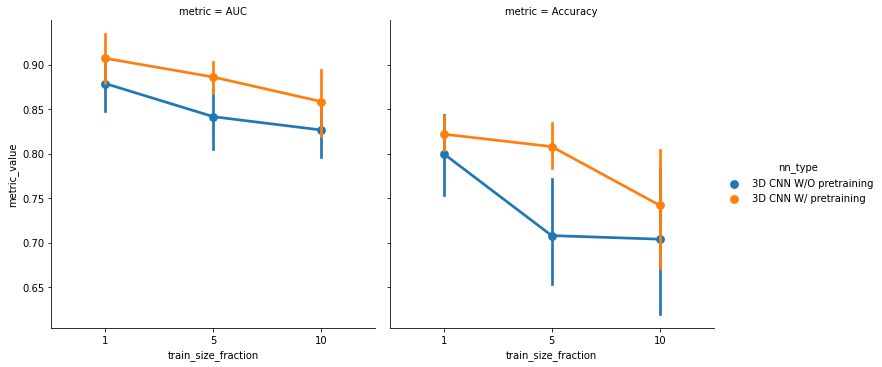

In [10]:
df = pd.read_csv("frac-training.csv")
sns.catplot(
    x="train_size_fraction",
    y="metric_value",
    hue="nn_type",
    col="metric",
    kind="point",
    data=df,
)